![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

Describe:

This problem was by far the most problematic to find a solution, after much searching I managed to find the correct term for a bibliographic survey in this area. The term in question that gave the best result was "Historical Document Image Binarization" with that I found a review [1] of the area and some other interesting articles [2,3] among which I highlight the "Binarization of Historical Document Images Using the
Local Maximum and Minimum "[3] which has an implementation available on the git hub:" https://gist.github.com/pebbie/2c17620e60c662950b02c4949b3010f2#file-su-py "which will be used to clean documents.

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

That said, let's  go to the pipeline

The ideia here is kind of simple:

Pipeline:
<blockquote> 
    <ol>
        <li>Applying the algorithm of local min and max from "https://gist.github.com/pebbie/2c17620e60c662950b02c4949b3010f2#file-su-py" in one image </li>
        <li>Applying a skew correction in the binarized image in previous step</li>
        <li>Applying the 1. and 2. steps in all dataset and save the cleanup images</li>
    </ol>
    
</blockquote>

In [1]:
# basic import 

import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import os

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
1. Applying the algorithm of local min and max from "https://gist.github.com/pebbie/2c17620e60c662950b02c4949b3010f2#file-su-py" in one image 

In [2]:
# This code snippet was just a copy paste from git hub

nfns = [
        lambda x: np.roll(x, -1, axis=0),
        lambda x: np.roll(np.roll(x, 1, axis=1), -1, axis=0),
        lambda x: np.roll(x, 1, axis=1),
        lambda x: np.roll(np.roll(x, 1, axis=1), 1, axis=0),
        lambda x: np.roll(x, 1, axis=0),
        lambda x: np.roll(np.roll(x, -1, axis=1), 1, axis=0),
        lambda x: np.roll(x, -1, axis=1),
        lambda x: np.roll(np.roll(x, -1, axis=1), -1, axis=0)
        ]

def localminmax(img, fns):
    mi = img.astype(np.float64)
    ma = img.astype(np.float64)
    for i in range(len(fns)):
        rolled = fns[i](img)
        mi = np.minimum(mi, rolled)
        ma = np.maximum(ma, rolled)
    result = (ma-mi)/(mi+ma+1e-16)
    return result

def numnb(bi, fns):
    nb = bi.astype(np.float64)
    i = np.zeros(bi.shape, nb.dtype)
    i[bi==bi.max()] = 1
    i[bi==bi.min()] = 0
    for fn in fns:
        nb += fn(i)
    return nb

def rescale(r,maxvalue=255):
    mi = r.min()
    return maxvalue*(r-mi)/(r.max()-mi)

def binarize_Su_et_al(img):
    gfn = nfns
    N_MIN = 4

    
    g = img
    I = g.astype(np.float64)


    cimg = localminmax(I, gfn)
    _, ocimg = cv2.threshold(rescale(cimg).astype(g.dtype), 0, 1, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    E = ocimg.astype(np.float64)


    N_e = numnb(ocimg, gfn)
    nbmask = N_e>0

    E_mean = np.zeros(I.shape, dtype=np.float64)
    for fn in gfn:
        E_mean += fn(I)*fn(E)

    E_mean[nbmask] /= N_e[nbmask]

    E_var = np.zeros(I.shape, dtype=np.float64)
    for fn in gfn:
        tmp = (fn(I)-E_mean)*fn(E)
        E_var += tmp*tmp

    E_var[nbmask] /= N_e[nbmask]
    E_std = np.sqrt(E_var)*.5

    R = np.ones(I.shape)*255
    R[(I<=E_mean+E_std)&(N_e>=N_MIN)] = 0

    return R.astype(np.uint8)

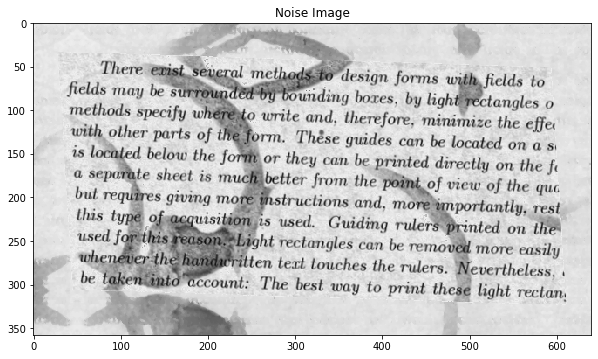

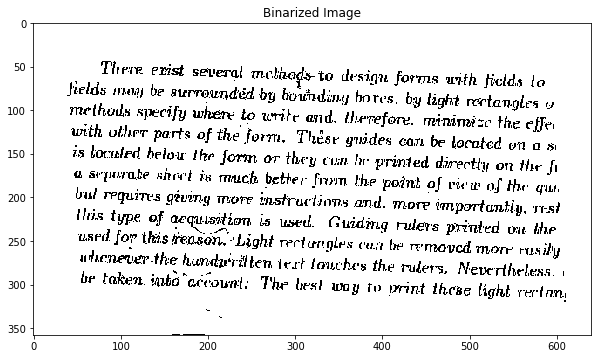

In [3]:
img_path_test = '/media/rafael/SSD 1Tb/NUVEO/data/candidate-data/01-DocumentCleanup/noisy_data/2.png'

img = cv2.imread(img_path_test)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(gray,  cmap='gray', vmin=0, vmax=255)
ax.set_title('Noise Image')
plt.show()

binarized = binarize_Su_et_al(gray)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(binarized,  cmap='gray', vmin=0, vmax=255)
ax.set_title('Binarized Image')
plt.show()

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

2. Applying a skew correction in the binarized image in previous step

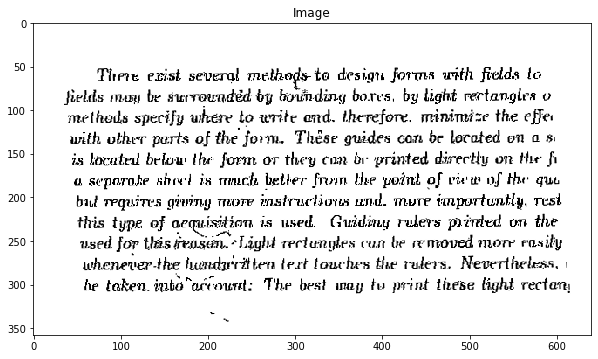

In [4]:
from scipy.ndimage import interpolation as inter

# This function rotates the image text to be horizontal by the histogram of the image
#
# This function recieves:
# image: array, the image to rotates
# delta: 
def correct_skew(image, delta=1, limit=15):
    
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2)
        return histogram, score

    scores = []
    angles = np.arange(-limit, limit + delta, delta) # create a bunch of angles
    
    # search for the best angle
    for angle in angles:
        histogram, score = determine_score(image, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    
    # rotate the image
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
              borderMode=cv2.BORDER_REPLICATE)

    return rotated

rotated = correct_skew(binarized)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(rotated,  cmap='gray', vmin=0, vmax=255)
ax.set_title('Image')
plt.show()

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

<blockquote> 
    3. Applying the 1. and 2. steps in all dataset and save the cleanup images
</blockquote>

In [5]:
noise_images_dir = '/media/rafael/SSD 1Tb/NUVEO/data/candidate-data/01-DocumentCleanup/noisy_data'

for image in os.listdir(noise_images_dir):
    
    # read the image
    img = cv2.imread(f'{noise_images_dir}/{image}')
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # apply the algorithm of local min and max
    binarized_img = binarize_Su_et_al(gray_img)
    
    # rotate the image
    rotated_img = correct_skew(binarized_img)
    
    # write the img to the dir
    filename = f'/media/rafael/SSD 1Tb/NUVEO/cv-test/01-DocumentCleanup/Clean_images/{image}'
    cv2.imwrite(filename, rotated_img)

REFERENCES:

[1] TENSMEYER, Chris; MARTINEZ, Tony. Historical Document Image Binarization: A Review.

[2] KAVALLIERATOU, Ergina; STATHIS, Stamatatos. Adaptive binarization of historical document images. In: 18th International Conference on Pattern Recognition (ICPR'06). IEEE, 2006. p. 742-745.

[3] SU, Bolan; LU, Shijian; TAN, Chew Lim. Binarization of historical document images using the local maximum and minimum. In: Proceedings of the 9th IAPR International Workshop on Document Analysis Systems. 2010. p. 159-166.